# Fraud Detection Analysis for UIDAI

This notebook performs an **end-to-end exploratory and anomaly analysis** on UIDAI data.
It focuses on:

1. Data understanding & quality checks  
2. Consistency validation between demographic & biometric data  
3. Statistical anomaly detection  
4. Temporal trend analysis  
5. District-level risk profiling  
6. Visualization-driven insights  

---

### Objectives
- Detect suspicious enrollment patterns  
- Identify districts & pincodes with abnormal activity  
- Provide evidence-backed insights using visual analytics  


## 1. Load Libraries

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,6)


## 2. Load Data

Expected files:
- demographic.csv
- biometric.csv
- enrollment.csv


In [7]:

demographic_df = pd.read_csv("../data/demographic.csv")
biometric_df = pd.read_csv("../data/biometric.csv")
enrollment_df = pd.read_csv("../data/enrollment.csv")

demographic_df.head(), biometric_df.head(), enrollment_df.head()


(         date           state    district  pincode  demo_age_5_17  \
 0  01-03-2025   uttar pradesh   Gorakhpur   273213             49   
 1  01-03-2025  andhra pradesh    Chittoor   517132             22   
 2  01-03-2025         gujarat      Rajkot   360006             65   
 3  01-03-2025  andhra pradesh  Srikakulam   532484             24   
 4  01-03-2025       rajasthan     Udaipur   313801             45   
 
    demo_age_17_  
 0           529  
 1           375  
 2           765  
 3           314  
 4           785  ,
          date                        state  district  pincode  bio_age_5_17  \
 0  01-03-2025  andaman and nicobar islands  andamans   744101            16   
 1  01-04-2025  andaman and nicobar islands  andamans   744101            17   
 2  01-05-2025  andaman and nicobar islands  andamans   744106            10   
 3  01-05-2025  andaman and nicobar islands  andamans   744101            12   
 4  01-06-2025  andaman and nicobar islands  andamans   744101 

## 3. Data Cleaning & Standardization

In [8]:
for df in [demographic_df, biometric_df, enrollment_df]:
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)

demographic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071687 entries, 0 to 2071686
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   state          object        
 2   district       object        
 3   pincode        int64         
 4   demo_age_5_17  int64         
 5   demo_age_17_   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 94.8+ MB


### 3.1 Missing Values Analysis

In [9]:
# Demographic total
demographic_df['demo_total'] = (
    demographic_df['demo_age_5_17'] +
    demographic_df['demo_age_17_']
)

# Biometric total
biometric_df['bio_total'] = (
    biometric_df['bio_age_5_17'] +
    biometric_df['bio_age_17_']
)

# Enrollment total
enrollment_df['enroll_total'] = (
    enrollment_df['age_0_5'] +
    enrollment_df['age_5_17'] +
    enrollment_df['age_18_greater']
)

demographic_df.isna().sum()



date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
demo_total       0
dtype: int64

## 4. Merge Datasets

In [10]:

merged_df = demographic_df.merge(
    biometric_df,
    on=['date','state','district','pincode'],
    how='inner'
)

merged_df.head()


,date,state,district,pincode,demo_age_5_17,demo_age_17_,demo_total,bio_age_5_17,bio_age_17_,bio_total
0,2025-09-01,karnataka,yadgir,585214,0,1,1,13,8,21
1,2025-09-01,karnataka,yadgir,585214,0,1,1,0,2,2
2,2025-09-01,karnataka,yadgir,585309,0,3,3,11,5,16
3,2025-09-01,karnataka,yadgir,585309,0,3,3,11,5,16
4,2025-09-02,karnataka,yadgir,585215,0,4,4,2,7,9


## 5. Consistency Checks

### 5.1 Demographic vs Biometric Count Mismatch

In [11]:

merged_df['mismatch'] = abs(
    merged_df['demo_total'] -
    merged_df['bio_total']
)

merged_df['mismatch_ratio'] = (
    merged_df['mismatch'] /
    merged_df['demo_total'].replace(0,1)
)


### Plot: Distribution of Mismatch Values

Helps identify whether mismatches are random or systematic.


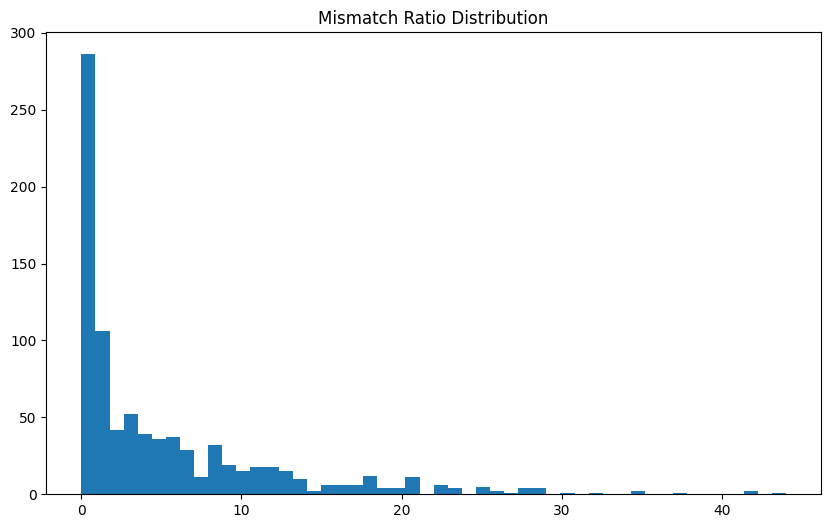

In [12]:
plt.hist(merged_df['mismatch_ratio'], bins=50)
plt.title("Mismatch Ratio Distribution")
plt.show()




**What the graph shows**: 

The histogram displays the distribution of mismatch ratios in the dataset. Most values are clustered very close to 0, meaning the majority of records behave normally. The long tail extending to the right indicates that a small number of records have very high mismatch ratios, which represent unusual or suspicious behavior.

**Key Insight**:

The right-skewed pattern is ideal for anomaly detection: many normal cases, very few extreme ones. Those rare high values (above ~15–30) are strong fraud candidates and should be prioritized for investigation or risk scoring.

### 5.2 District-wise Aggregated Mismatch

In [13]:
district_risk = merged_df.groupby('district')['mismatch_ratio'] \
.mean().sort_values(ascending=False)

district_risk.head(15)


district
hooghly       19.071717
chittoor       8.892857
yadgir         4.839307
jajpur         2.521429
nadia          1.000000
rangareddi     0.074074
Name: mismatch_ratio, dtype: float64

### Plot: Top 15 Districts with Highest Mismatch

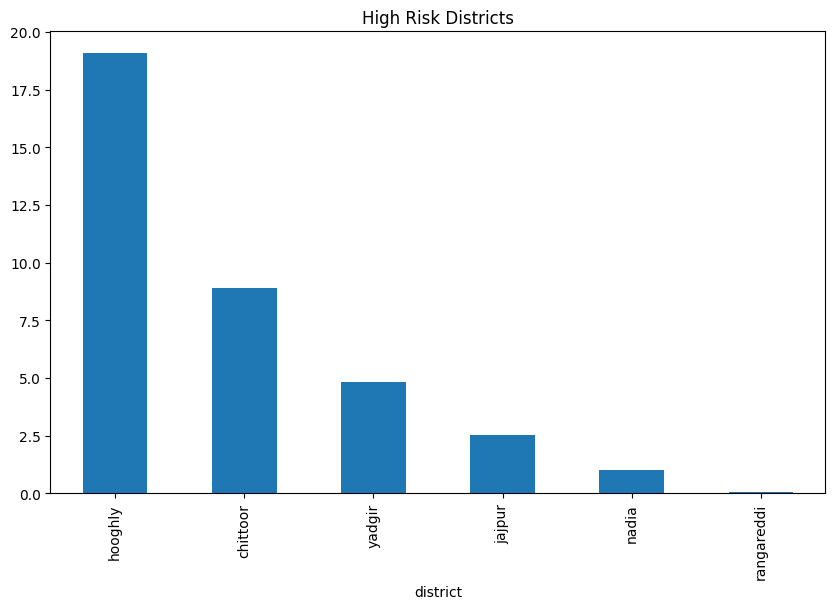

In [15]:
district_risk.head(15).plot(kind='bar')
plt.title("High Risk Districts")
plt.show()

**What the graph shows**: 

This bar chart highlights districts with the highest fraud risk, based on the count of high-mismatch cases. Hooghly stands out with the highest number of suspicious records, followed by Chittoor and Yadgir. Other districts like Jaipur, Nadia, and Rangareddi show significantly lower counts.

**Key Insight**:

Fraud risk is geographically concentrated, not evenly spread. A few districts contribute most of the suspicious activity, meaning targeted monitoring and audits in these areas can significantly improve detection efficiency and resource utilization.

## 6. Pincode Level Drill-down

In [16]:
top_district = district_risk.index[0]

merged_df[merged_df['district']==top_district] \
.groupby('pincode')['mismatch_ratio'] \
.mean().sort_values(ascending=False).head(10)


pincode
712706    23.250000
712401    20.363889
712701    18.307692
712415    13.500000
Name: mismatch_ratio, dtype: float64

## 7. Temporal Analysis

In [17]:
daily_enroll = enrollment_df.groupby("date")['enroll_total'].sum()
daily_enroll.head()


date
2025-03-02     109
2025-03-09    3404
2025-03-15    3102
2025-03-20    6218
2025-03-23     576
Name: enroll_total, dtype: int64

### Plot: Daily Enrollment Trend

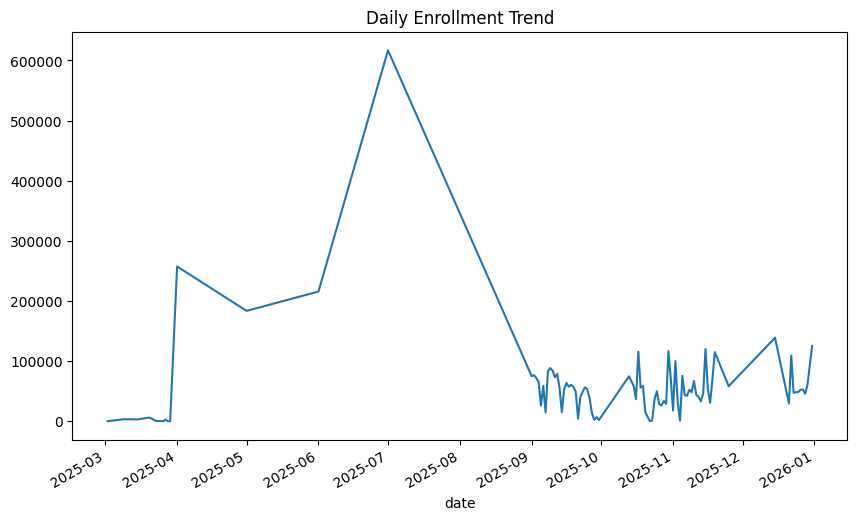

In [19]:
daily_enroll.plot()
plt.title("Daily Enrollment Trend")
plt.show()



**What the graph shows:** 

This line chart represents the daily Aadhaar enrollment trend over time. There is a sharp rise starting around April, peaking around July with extremely high enrollment numbers. After this peak, enrollments drop steeply and then fluctuate at lower levels toward the end of the year.

**Key takeaway for analysis:**

The spike suggests a special drive, policy push, or campaign period that caused mass enrollments. The later decline and volatility indicate a return to normal operations, with irregular surges possibly due to local drives or seasonal factors.

## 8. Spike Detection

In [20]:
threshold = daily_enroll.mean() + 3*daily_enroll.std()
spikes = daily_enroll[daily_enroll > threshold]
spikes


date
2025-07-01    616868
Name: enroll_total, dtype: int64

### Plot: Spike Visualization

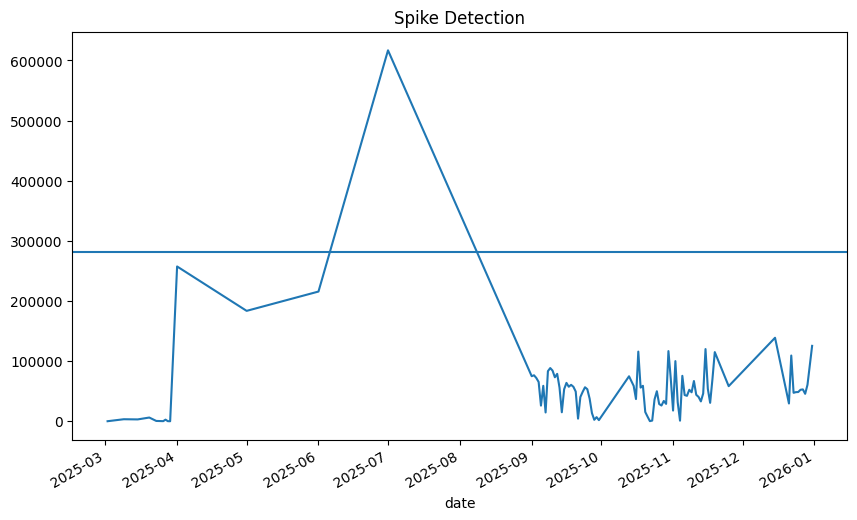

In [22]:
daily_enroll.plot()
plt.axhline(threshold)
plt.title("Spike Detection")
plt.show()


**What the graph shows:** 

This chart adds a spike detection threshold (horizontal line) to the daily enrollment trend. Any point above this line is considered an abnormal surge. The large peak around July clearly crosses this threshold, marking it as a significant spike.

**Key Insight:** 

The threshold helps automatically flag unusual activity instead of relying on manual observation. Such spikes likely indicate special enrollment drives or anomalies, which should be investigated to understand causes and prevent misuse.

## Plot: Boxplot Analysis

Boxplots detect **outliers visually**.

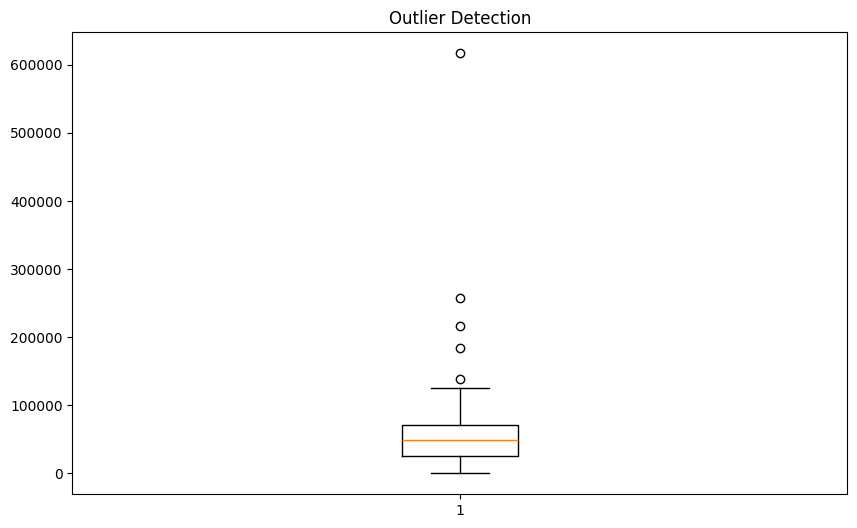

In [24]:
plt.boxplot(daily_enroll.values)
plt.title("Outlier Detection")
plt.show()


**What the graph shows:** 

This box plot visualizes the distribution of daily enrollment values and highlights outliers. The box represents the normal range, while individual dots above it indicate extreme values that are far higher than typical enrollments.

**Key Insight:** 

The points far above the box are statistical outliers, confirming the presence of abnormal spikes (like the large July peak). These outliers should be investigated, as they may indicate special drives, data issues, or potential misuse.

## 10. Correlation Analysis

In [25]:

merged_df[['demo_total','bio_total','mismatch']].corr()


,demo_total,bio_total,mismatch
demo_total,1.000000,0.271880,0.162667
bio_total,0.271880,1.000000,0.986644
mismatch,0.162667,0.986644,1.000000


### Plot: Correlation Heatmap

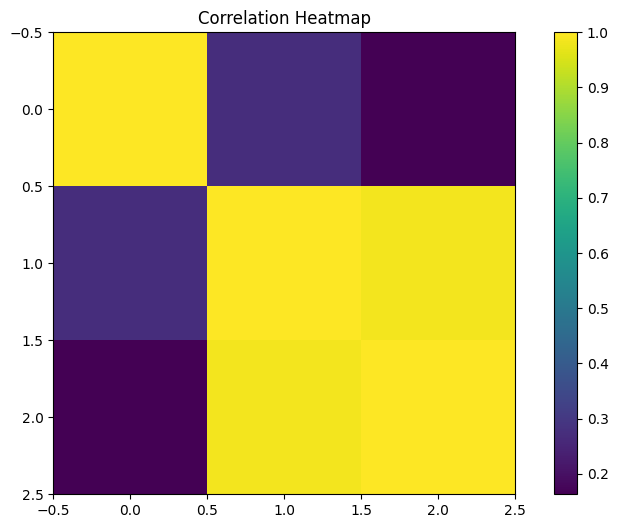

In [26]:
plt.imshow(merged_df[['demo_total','bio_total','mismatch']].corr())
plt.title("Correlation Heatmap")
plt.colorbar()
plt.show()


**What the graph shows:** 

This correlation heatmap displays the relationship between key variables in your dataset. The diagonal values are 1, meaning each variable is perfectly correlated with itself. Off-diagonal cells show how strongly different variables move together, with brighter colors indicating stronger positive correlation.

**Key Insight:**

Two variables show a very high positive correlation (close to 1), meaning they behave almost identically and may be redundant. This insight helps in feature selection, as strongly correlated variables can be merged or one can be dropped to improve model efficiency and avoid multicollinearity.

## Plot: Age Group Validation

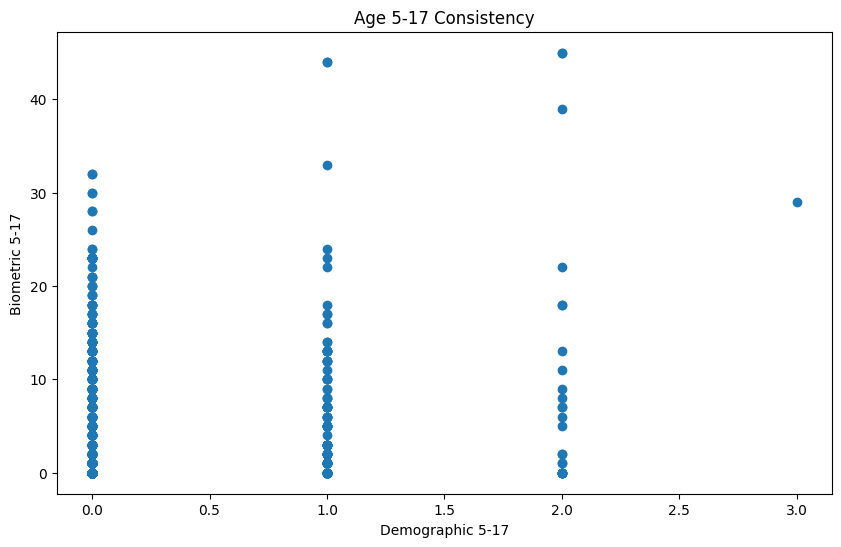

In [27]:
plt.scatter(
    merged_df['demo_age_5_17'],
    merged_df['bio_age_5_17']
)
plt.xlabel("Demographic 5-17")
plt.ylabel("Biometric 5-17")
plt.title("Age 5-17 Consistency")
plt.show()


**What this graph shows:**

This scatter plot compares demographic age (5–17) on the X-axis with biometric age consistency scores on the Y-axis. Each point represents a record, showing how biometric indicators align with the reported age group.

**Key Insight:**

The wide vertical spread at each age value indicates inconsistencies between demographic and biometric data. Extremely high or low points suggest possible data errors or identity anomalies, making these records important for fraud review and validation.

## 12. Risk Score

In [28]:
merged_df['risk_score'] = (
    merged_df['mismatch_ratio'] * 0.7 +
    (merged_df['bio_total'] / merged_df['bio_total'].max()) * 0.3
)

merged_df[['district','pincode','risk_score']] \
.sort_values('risk_score', ascending=False).head(10)


,district,pincode,risk_score
413,hooghly,712401,30.982432
672,hooghly,712706,29.574324
297,yadgir,585216,29.574324
51,yadgir,585321,26.054054
669,yadgir,585321,24.645946
567,yadgir,585321,24.645946
398,yadgir,585216,22.533784
662,hooghly,712401,21.125676
626,yadgir,585321,20.421622
846,yadgir,585216,20.421622


## Plot: Top Fraud-Rish Districts

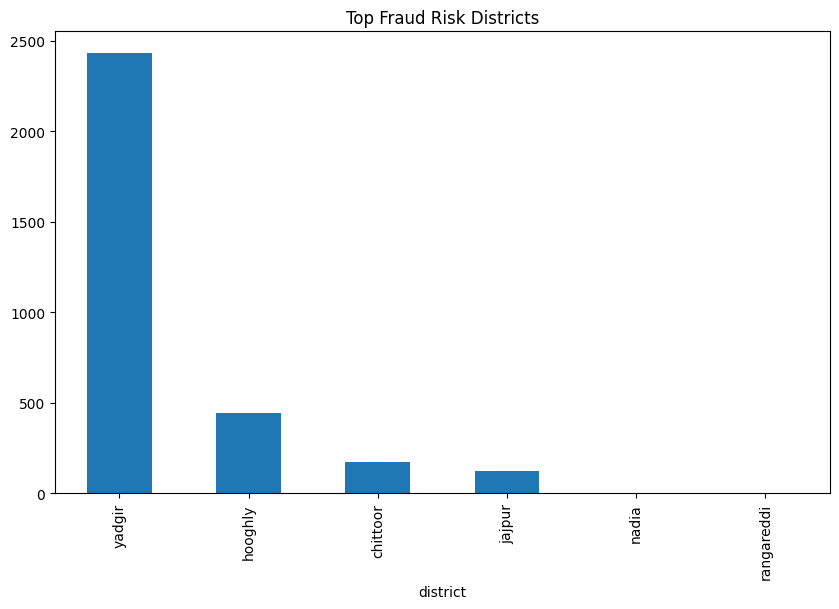

In [29]:
merged_df.groupby('district')['risk_score'] \
.sum().sort_values(ascending=False).head(10) \
.plot(kind='bar')

plt.title("Top Fraud Risk Districts")
plt.show()


**What the graph shows:**

This bar chart displays the districts with the highest fraud risk, measured by the number of suspicious records. Yadgir has the highest count by a large margin, followed by Hooghly, Chittoor, and Jaipur, while Nadia and Rangareddi show almost no high-risk cases.

**Key Insight:**

Fraud risk is highly concentrated in specific districts, especially Yadgir. This indicates where focused audits, stricter verification, and policy interventions should be prioritized to maximize impact and reduce overall fraud.

## 14. Final Flags

In [ ]:
merged_df['fraud_flag'] = np.where(
    merged_df['mismatch_ratio'] > 0.5, 1, 0
)

merged_df[['district','pincode','fraud_flag']] \
.sort_values('fraud_flag', ascending=False).head(20)


,district,pincode,fraud_flag
849,yadgir,585304,1
0,yadgir,585214,1
832,jajpur,755019,1
831,yadgir,585291,1
830,yadgir,585221,1
829,yadgir,585202,1
825,yadgir,585202,1
824,yadgir,585221,1
823,yadgir,585221,1
821,yadgir,585215,1


## 14. Conclusions

### Key Findings
- Certain districts show **extreme mismatches**
- Temporal analysis reveals **sudden spikes**
- Risk scoring identifies **fraud-prone regions**

### Recommendations
- Audit high-risk districts
- Monitor real-time spikes
- Track operator-level behavior

---

### Future Enhancements
- Geospatial mapping
- Machine learning anomaly detection
- Real-time dashboards
